# Pre-trained Model Exploration

### Goal
In this notebook, you will begin playing with generative models

In [2]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [3]:
%tensorflow_version 1.x
import os
import pickle
import warnings
import numpy as np
import PIL

TensorFlow 1.x selected.


In [5]:
from tensorflow.python.util import module_wrapper
module_wrapper._PER_MODULE_WARNING_LIMIT = 0


import stylegan
from stylegan.dnnlib import tflib
from stylegan import config

In [6]:
tflib.init_tf()

path='stylegan/'
if "stylegan" not in os.getcwd():
    os.chdir(path)

In [7]:
url = 'https://bitbucket.org/ezelikman/gans/downloads/karras2019stylegan-ffhq-1024x1024.pkl'
with stylegan.dnnlib.util.open_url(url,cache_dir=stylegan.config.cache_dir) as f:
  _G,_D, Gs =pickle.load(f)
  print('StyleGAN package loaded successfully!')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN package loaded successfully!


In [8]:
truncation=0.7

In [9]:
rnd=np.random.RandomState(42)


In [10]:
batch_size=4

In [11]:
input_shape=Gs.input_shape[1]
noise_vectors=rnd.randn(batch_size,input_shape)


In [14]:
fmt=dict(func=tflib.convert_images_to_uint8,nchw_to_nhwc=True)
images=Gs.run(noise_vectors,None,truncation_psi=truncation,randomize_noise=False,output_transform=fmt)


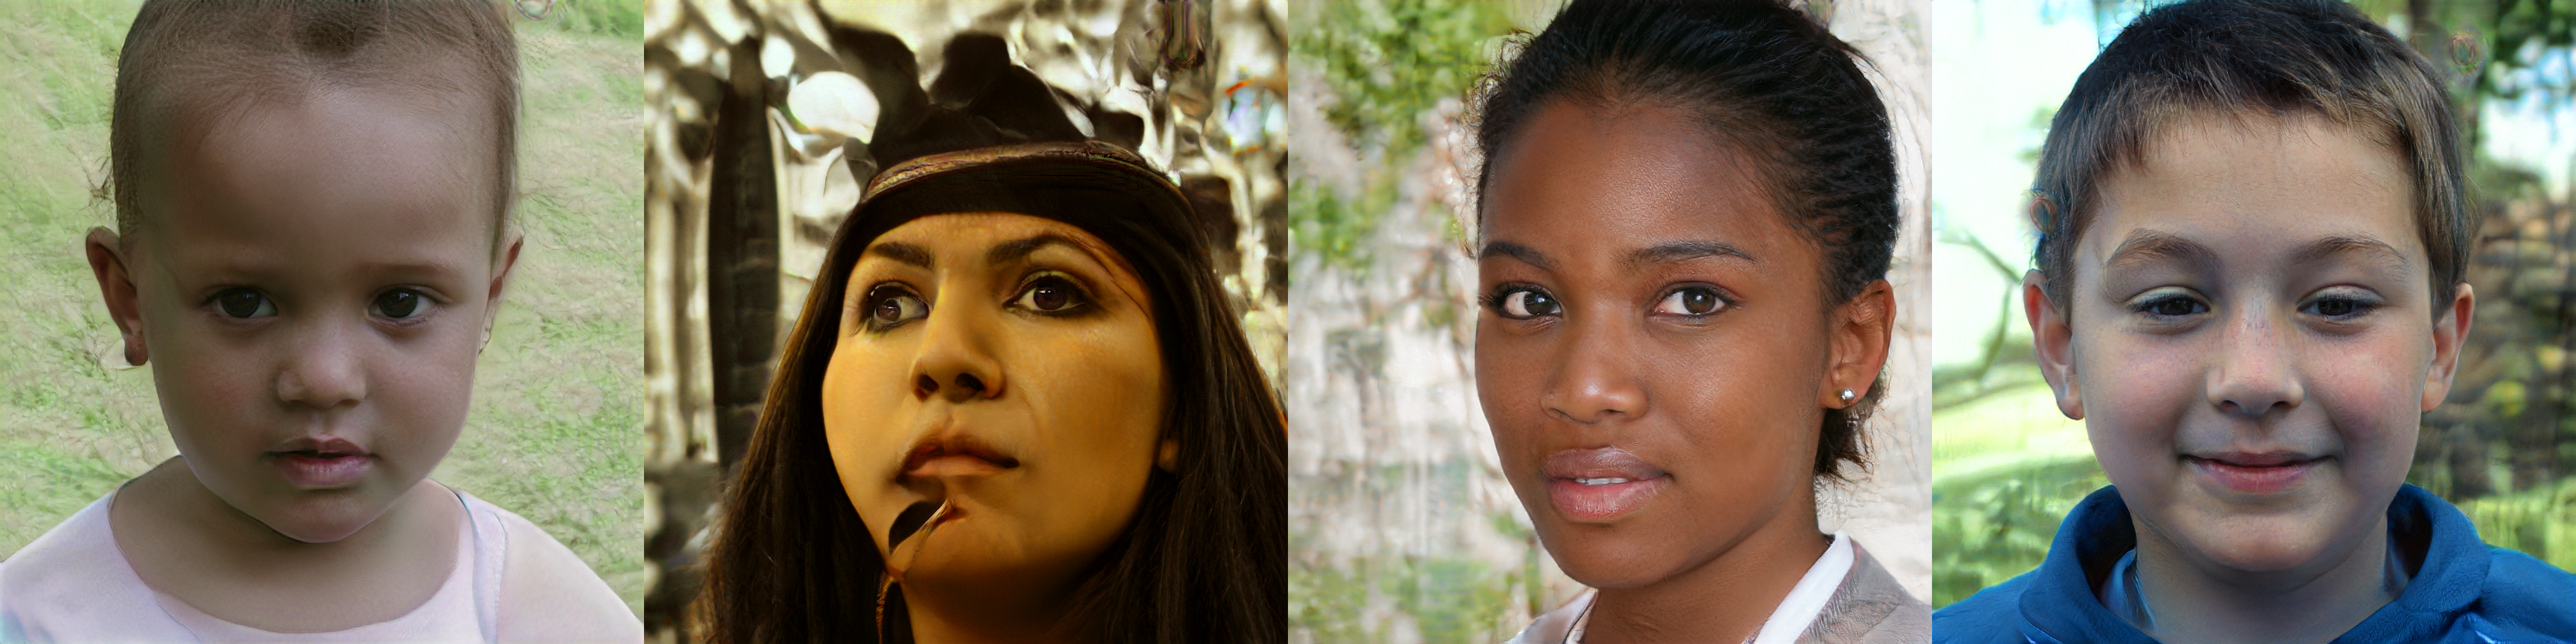

In [15]:
os.makedirs(config.result_dir,exist_ok=True)
png_filename=os.path.join(config.result_dir,'example.png')
if batch_size > 1:
  img = np.concatenate(images,axis=1)
else:
  img= images[0]

PIL.Image.fromarray(img,'RGB').save(png_filename)

# Check the images out!
from IPython.display import Image
Image(png_filename, width=256*batch_size, height=256)

## BigGAN - objects
#### Here are some objects generated by a different GAN (called BigGAN) of a dog, mountain, butterfly, and hamburger. These different objects are called classes.
#### You can play with the different classes that BigGAN can generate below.
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Examples-of-High-Quality-Class-Conditional-Images-Generated-by-BigGAN.png)

In [17]:
import numpy as np
import os
from io import StringIO
from tqdm import tqdm
from random import random
from PIL import ImageFont, ImageDraw ,ImageEnhance
from scipy.stats import truncnorm
from google.colab import files
import IPython.display
import tensorflow as tf

import tensorflow_hub as hub

In [20]:
module_path=  'https://tfhub.dev/deepmind/biggan-deep-256/1'
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}

output=module(inputs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [21]:
print('Loaded the BigGAN module. Here are its input and outputs sizes:')
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print('\nOutput:', output)

Loaded the BigGAN module. Here are its input and outputs sizes:
Inputs:
   z: Tensor("z:0", shape=(?, 128), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


In [22]:
# Get the different components of the input
noise_vector = input_z = inputs['z']
label = input_y = inputs['y']
input_trunc = inputs['truncation']

# Get the sizes of the noise vector and the label
noise_vector_size = input_z.shape.as_list()[1]
label_size = input_y.shape.as_list()[1]

print(f'Components of input are set.')
print(f'Noise vector is size {noise_vector_size}. Label is size {label_size}.')

Components of input are set.
Noise vector is size 128. Label is size 1000.


In [23]:
# Function to truncate the noise vector
def truncated_noise_vector(batch_size, truncation=1., seed=42):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, noise_vector_size), random_state=state)
  return truncation * values

print(f'Function declared.')

Function declared.


In [24]:
def one_hot(label, label_size=label_size):
  '''
  Function to turn label into a one-hot vector.
  This means that all values in the vector are 0, except one value that is 1, 
  which represents the class label, e.g. [0 0 0 0 1 0 0].
  '''
  label = np.asarray(label)
  if len(label.shape) <= 1:
    index = label
    index = np.asarray(index)
    if len(index.shape) == 0:
      index = np.asarray([index])
    assert len(index.shape) == 1
    num = index.shape[0]
    label = np.zeros((num, label_size), dtype=np.float32)
    label[np.arange(num), index] = 1
  assert len(label.shape) == 2
  return label

print(f'Function declared.')

Function declared.


In [25]:
def sample(sess, noise, label, truncation=1., batch_size=8,
           label_size=label_size):
  '''
  Function to sample images from the model.
  Inputs include the noise vector, label, truncation, 
  and batch size (number of images to generate).
  '''
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'
                     .format(noise.shape[0], label.shape[0]))
  label = one_hot(label, label_size)
  ims = []
  print(f"Generating images...")
  for batch_start in tqdm(range(0, num, batch_size)):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

print(f'Function declared.')

Function declared.


In [26]:
'''
Functions for saving and visualizing images in a grid.
'''
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  path = 'results/biggan-example.png'
  img = PIL.Image.fromarray(a)
  img.save(path, format)
  try:
    disp = IPython.display.display(IPython.display.Image(path))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

print(f'Functions declared.')

Functions declared.


In [27]:
# Initialize TensorFlow
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

print('TensorFlow initialized.')

TensorFlow initialized.


In [28]:

Class = "17) jay" 
Truncation = 1 

  0%|          | 0/1 [00:00<?, ?it/s]

Generating images...


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


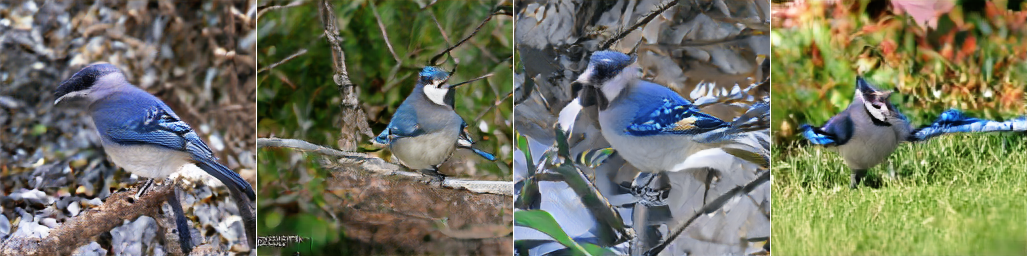

In [29]:
# Set number of samples
num_samples = 4

# Create the noise vector with truncation (you'll learn about this later!)
noise_vector = truncated_noise_vector(num_samples, Truncation)

# Select the class to generate
label = int(Class.split(')')[0])

# Sample the images with the noise vector and label as inputs
ims = sample(sess, noise_vector, label, truncation=Truncation)

# Display generated images
imshow(imgrid(ims, cols=min(num_samples, 5)))